In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit

from matplotlib import colors as mcolors        # Packages to define custom colormaps
from matplotlib.animation import FuncAnimation  # and animations
plt.rcParams['figure.dpi'] = 150

import matplotlib

In [2]:
# The following funtion identifies vortex and antivortex in a lattice
# The input is a lattice which has to be inspected.
# It returns the numer of vortex, antivortex, and  x,y coordinates of vortex and antivortex.
def vortex(lattice):
    size = len(lattice)
    vortex_counter = 0
    antivortex_counter = 0
    coor_vortex_x = []
    coor_vortex_y = []
    
    coor_antivortex_x = []
    coor_antivortex_y = []
    for i in range(size - 1):
        for j in range(size - 1):
            spin1 = lattice[i][j]
            spin2 = lattice[i+1][j]
            spin3 = lattice[i+1][j+1]
            spin4 = lattice[i][j+1]
            
            angle1 = spin2 - spin1 # Difference in spins gives the angle.
            angle2 = spin3 - spin2
            angle3 = spin4 - spin3
            angle4 = spin1 - spin4
            
            sum_angle = 0
            
            # To make sure that the angles lie in the range -pi to pi.
            if -np.pi < angle1 < np.pi:
                sum_angle = sum_angle + angle1
            elif angle1 > np.pi:
                angle1 = angle1 - 2*np.pi
                sum_angle = sum_angle + angle1
            else:
                angle1 = angle1 +  2*np.pi
                sum_angle = sum_angle + angle1
                
            if -np.pi < angle2 < np.pi:
                sum_angle = sum_angle + angle2
            elif angle2 > np.pi:
                angle2 = angle2 - 2*np.pi
                sum_angle = sum_angle + angle2
            else:
                angle2 = angle2 +  2*np.pi
                sum_angle = sum_angle + angle2
                
            if -np.pi < angle3 < np.pi:
                sum_angle = sum_angle + angle3
            elif angle1 > np.pi:
                angle3 = angle3 - 2*np.pi
                sum_angle = sum_angle + angle3
            else:
                angle3 = angle3 +  2*np.pi
                sum_angle = sum_angle + angle3
            
            if -np.pi < angle4 < np.pi:
                sum_angle = sum_angle + angle4
            elif angle4 > np.pi:
                angle4 = angle4 - 2*np.pi
                sum_angle = sum_angle + angle4
            else:
                angle4 = angle4 +  2*np.pi
                sum_angle = sum_angle + angle4
            
            if abs(2*np.pi - sum_angle) < 0.001: # Selection criteria for vortex
                vortex_counter = vortex_counter + 1
                coor_vortex_x = coor_vortex_x + [i]
                coor_vortex_y = coor_vortex_y + [j]
                
            if abs(2*np.pi + sum_angle) < 0.001: # Selection criteria for antivortex
                antivortex_counter = antivortex_counter + 1
                coor_antivortex_x = coor_antivortex_x + [i]
                coor_antivortex_y = coor_antivortex_y + [j]
                
    return vortex_counter, antivortex_counter, coor_vortex_x, coor_vortex_y, coor_antivortex_x, coor_antivortex_y

In [3]:
# This function creates a lattice with random spins in the range 0 to 2 pi
# The input parameter is size
# The return is a randomized spin array of dimensions 2, and length, width = size
def initial_lattice(size):
    larr = np.zeros((size, size))
    for i in range(size):
        for j in range(size):
            larr[i][j] = 2*np.pi*np.random.rand()
    return larr

In [4]:
# the metropolis algorithm
# This function does one monte carlo sweep
# The input parameter is energy of the system, the lattice, temperature, and J
# It returns the new energy and lattice, after the sweep
@njit
def metropolis(energy, lat, temp, J = 1):
    L = np.shape(lat)[0]
    N = L**2
    
    for i in range(N):
        # choose a random point (x,y) in the lattice
        x = int(np.random.uniform(0,1)*L)
        y = int(np.random.uniform(0,1)*L)
        
        # make a change in the spin and call it a trial_spin
        trial_spin = lat[x][y] + 0.25*np.pi*(2*np.random.uniform(0,1)-1)
        
        # if the trial spin is greater or less than np.pi and -np.pi, we take modulus to keep in range (-pi,pi)
        if trial_spin > np.pi:
            trial_spin = trial_spin % np.pi
        elif trial_spin < -np.pi:
            trial_spin = trial_spin % -np.pi
        else:
            trial_spin = trial_spin
            

        EOld = -J*(np.cos(lat[x][y] - lat[(x+1)%L][y]) + np.cos(lat[x][y] - lat[x-1][y]) + np.cos(lat[x][y] - lat[x][(y+1)%L]) + np.cos(lat[x][y] - lat[x][y-1]))
        
        # define the new energy using the trial spin
        ENew = -J*(np.cos(trial_spin - lat[(x+1)%L][y]) + np.cos(trial_spin - lat[x-1][y]) + np.cos(trial_spin - lat[x][(y+1)%L]) + np.cos(trial_spin - lat[x][y-1]))
        
        # the change in energy
        delE = ENew - EOld
        
        boltz = np.exp(-delE/temp)
        
        # accept the trial spin if: dE <= 0 or a random number is less than the Boltzmann factor
        if delE <= 0 or np.random.uniform(0,1) < boltz:
            lat[x][y] = trial_spin
            energy = energy + delE
            
    return energy, lat

In [5]:
# This function simulates the system for n_mcs monte carlo sweeps
# The input parameter is the lattice size, the lattice, the temperature,and number of sweeps required.
# It returns the energy and magnetisation of the system over the sweeps.
@njit
def simulate(L, lattice, temp, n_mcs = 1000):
    J = 1
    N = L**2
    lat = lattice 

    energy = np.zeros(n_mcs)
    mag = np.zeros_like(energy)
    
    init_energy = 0
    
    
    # loop over all the lattice sites to find the total initial energy
    for x in range(L):
        for y in range(L):
            init_energy += (np.cos(lat[x][y] - lat[(x+1)%L][y]) + np.cos(lat[x][y] - lat[x-1][y]) + np.cos(lat[x][y] - lat[x][(y+1)%L]) + np.cos(lat[x][y] - lat[x][y-1]))
            
    energy[0] = -J*init_energy*0.5 # divide by overcounting factor
    for m in range(1,n_mcs):
        energy[m], lat = metropolis(energy[m-1], lat=lat, temp=temp, J=1) # Makes sure the previous lattice is used
        mag[m] = np.sum(lat)
    
    return energy, mag 

In [6]:
# This functions looks at the phase transition by looking at the system parameters.
# The default parameters are used as the input. 
# It doesnt return anything but displays the phase transition graphs.
# Ideal number of iterations is 1000000
def systemParameters(Ls=[32], colors=['black', 'darkgreen', 'firebrick'], markers=['o', 'v', '1','2','3']):
    
    # Parameters
    J = 1
    h = 0
    ############

    temp = np.linspace(0.01,2,20)    
    
    avE   =  np.zeros((len(Ls), len(temp)))                          
    avEsq =  np.zeros_like(avE)                          
    
    avM   =  np.zeros((len(Ls), len(temp)))                          
    avMsq =  np.zeros_like(avM)                         
    
    for Li in range(len(Ls)):                            
        L = Ls[Li]; N = L**2
        
        # we plot the average energy per spin, specific heat per spin, average magnetization per spin, susceptibility
        for i in range(len(temp)):
            lattice = initial_lattice(L)
            # call the simulate function which returns the energy and magnetization per spin, we choose the values after the model stabilizes
            energy, mag = simulate(L, lattice, temp[i], n_mcs = 100_00)
            
            avE[Li][i] = np.mean(energy[len(energy)//2:])  
            avEsq[Li][i] = np.mean(energy[len(energy)//2:]**2)
            avM[Li][i] = abs(np.mean(mag[len(mag)//2:]))
            avMsq[Li][i] = np.mean(mag[len(mag)//2:]**2)
            
        
        # plot for average energy per spin
        plt.plot(temp, avE[Li]/N, color=colors[Li], marker=markers[Li], label=r"$(L="+str(L)+")$") 
        plt.ylabel(r"$\langle E \rangle$ (per spin)")
        plt.xlabel(r"$T$")
        plt.legend()
        plt.show()
        
        # plot for c_v per spin
        plt.plot(temp, ((avEsq[Li]-avE[Li]*2))/(temp**2 * N**2), color=colors[Li], marker=markers[Li], label=r"$(L="+str(L)+")$") 
        plt.ylabel(r"$C_V$ (per spin)")
        plt.xlabel(r"$T$")
        plt.legend()
        plt.show()
        
        # plot for average magnetization per spin
        plt.plot(temp, avM[Li]/N, color=colors[Li], marker=markers[Li], label=r"$(L="+str(L)+")$") 
        plt.ylabel(r"$m = \langle M \rangle/N$")
        plt.xlabel(r"$T$")
        plt.legend()
        plt.show()
        
        # plot for susceptibility
        plt.plot(temp, ((avMsq[Li] - avM[Li]*2))/(temp*N**2), color=colors[Li], marker=markers[Li], label=r"$(L="+str(L)+")$") 
        plt.ylabel(r"$\chi$")
        plt.xlabel(r"$T$")
        plt.legend()
        plt.show()

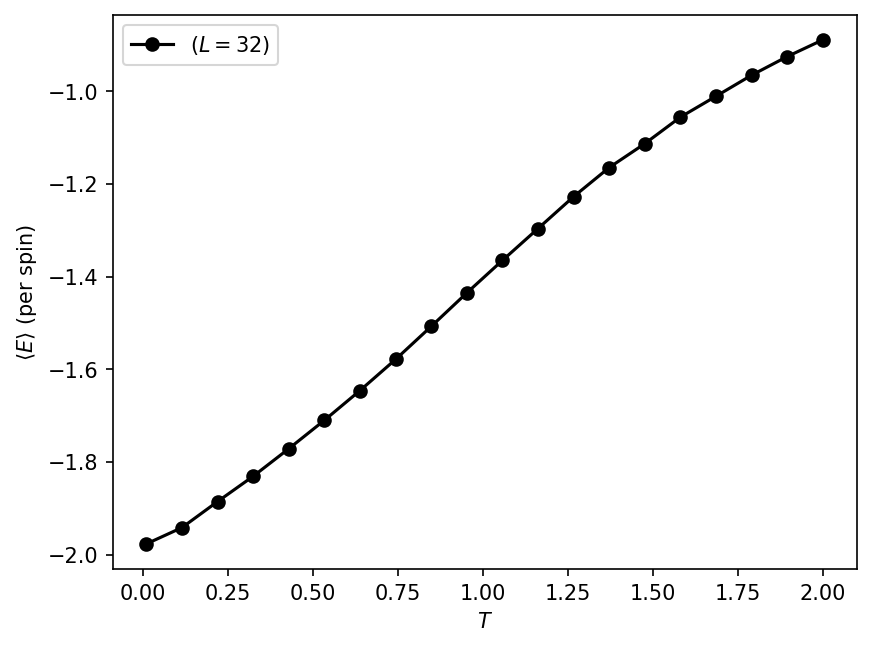

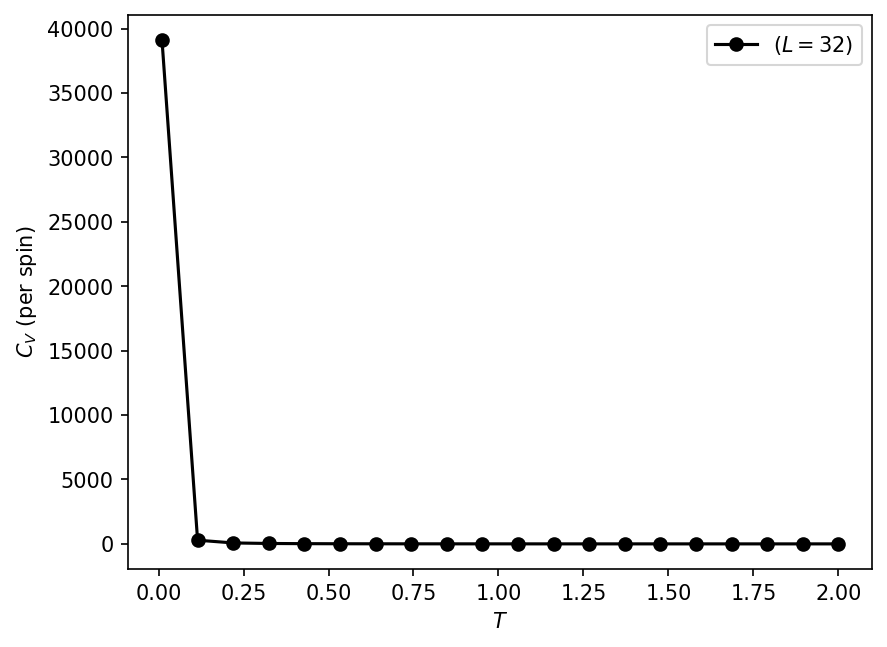

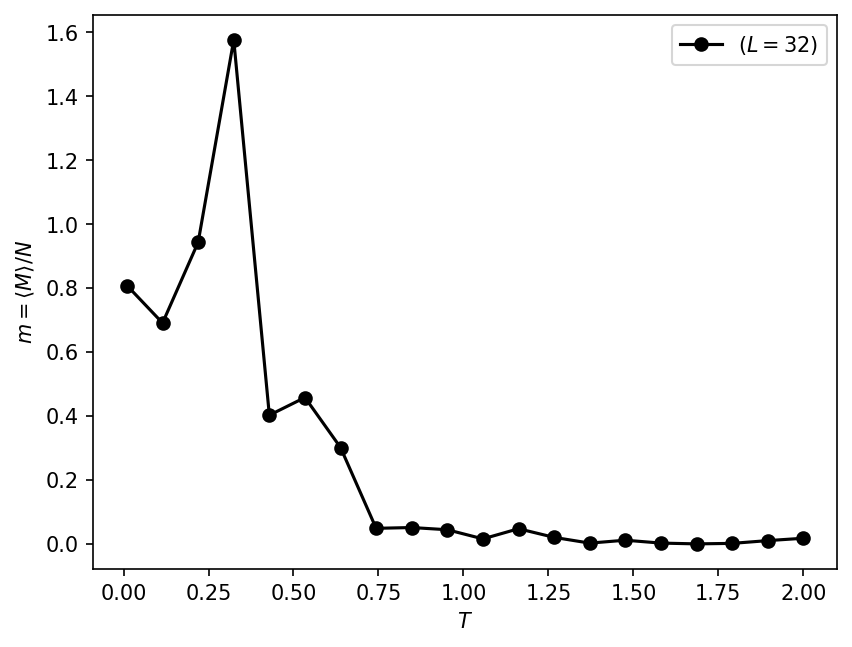

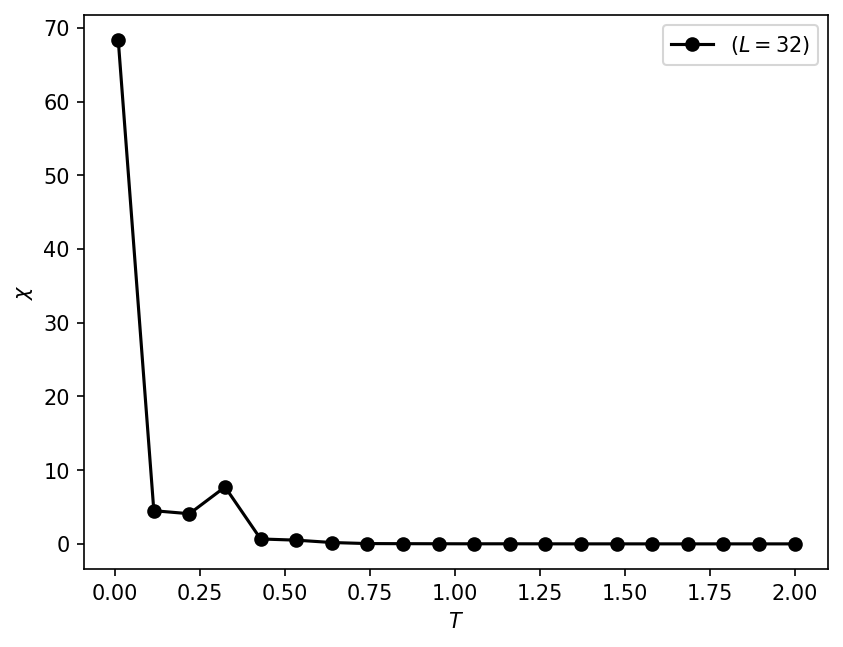

CPU times: user 42.8 s, sys: 337 ms, total: 43.1 s
Wall time: 43.6 s


In [7]:
%%time
systemParameters()

The above set of graph shows how the system parameters, namely energy, specific heat, magnetization, and magnetic susceptibility change across temperature. For higher iterations the graph becomes much more accurate. All the graphs are what we expect them to be, and point towards the same critical temperature. For better results, please refer to the report. 

In [8]:
# Extremely similar to the earlier simulate function
# The only difference is that the lattice is also returned
def simulateLattice(size, lattice, T, n_mcs = 1_000):
    
    systemEnergy = np.zeros(n_mcs)   # Array to store the system's energy every mcs
    m = np.zeros_like(systemEnergy)  # Array to store the system's magnetisation every mcs
    lat = np.zeros((n_mcs, size, size))
    
    initialEnergy = 0
    initialM = 0
    for y in range(size):
        for x in range(size):
            initialEnergy += 0.5*(-(np.cos(lattice[y][x] - lattice[(y-1)%size][x]) + 
                np.cos(lattice[y][x] - lattice[(y+1)%size][x]) + 
                np.cos(lattice[y][x] - lattice[y][(x+1)%size]) + 
                np.cos(lattice[y][x] - lattice[y][(x-1)%size])))
            initialM += lattice[y][x]
            
    systemEnergy[0] = initialEnergy/size**2
    m[0] = initialM/size**2
    lat[0] = lattice
    
    for i in range(1,n_mcs):
        systemEnergy[i], lat[i] = metropolis(systemEnergy[i-1], lat[i-1], T)
        m[i] = np.mean(lat[i])

    return systemEnergy[n_mcs//2:], m[n_mcs//2:], lat # [n_mcs//2:] is put so that the equilibrium values are returned.

In [9]:
# This function is an extension of the simulateLattice function
# The addition is that in this function, the initial lattice is created
# It returns the energy of the lattices, the lattices and their magnetisation
def equilibrium(size, T, itr):
    lattice = initial_lattice(size)
    systemEnergy, m , lat= simulateLattice(size, lattice, T, n_mcs = itr)
    return systemEnergy,lat, m

In [26]:
%%time
size = 16
energy, lat3, m= equilibrium(size, T=0.01, itr = 10000)
Lat3 = np.array(lat3)

CPU times: user 468 ms, sys: 19.5 ms, total: 488 ms
Wall time: 480 ms


<IPython.core.display.Javascript object>


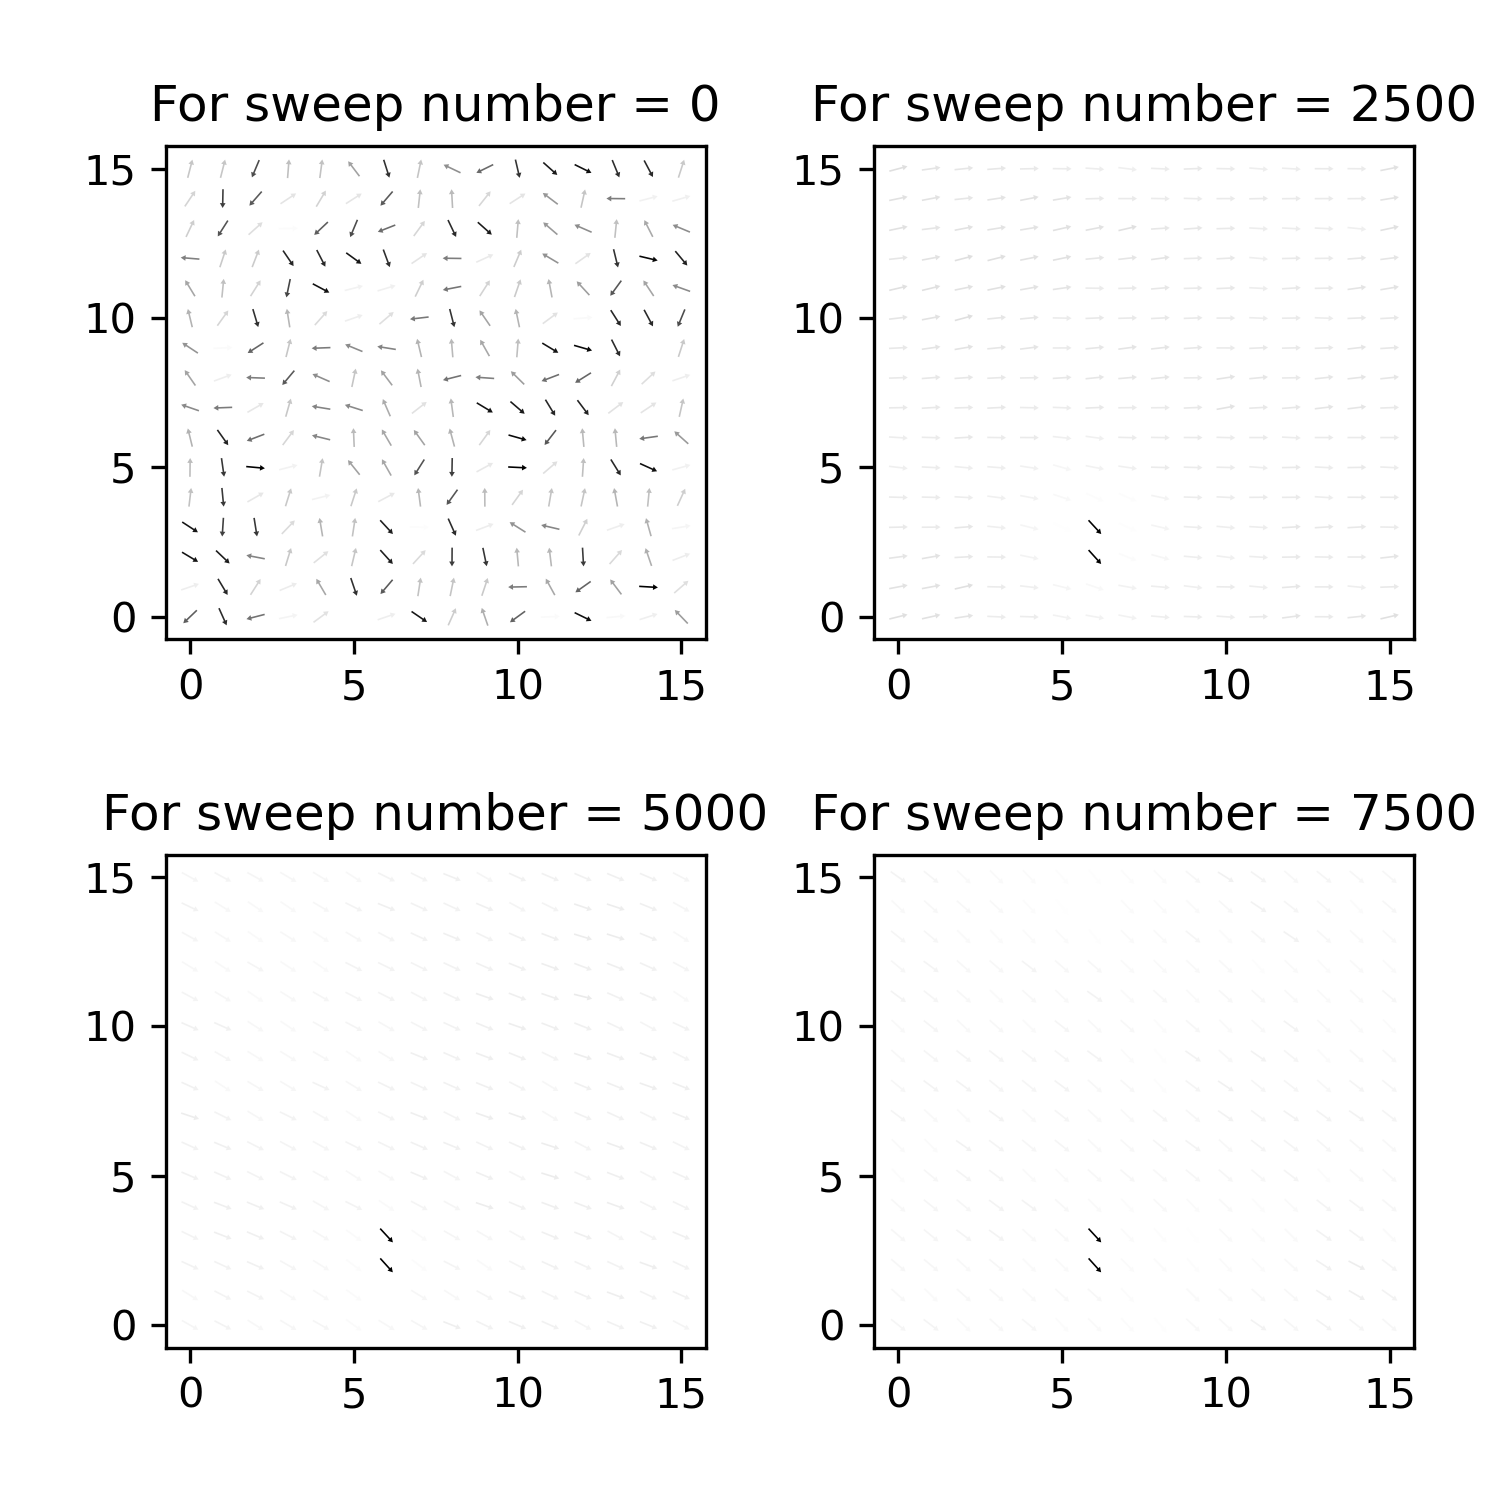

In [27]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(5,5))
lenght = len(Lat3)
u0 = np.sin(Lat3[0])
v0 = np.cos(Lat3[0])
c0 = Lat3[0]


axes[0][0].quiver(v0, u0, c0, pivot="mid", headwidth=3.5, headaxislength=3, headlength=3, width=0.003, cmap ='binary')
axes[0][0].set_title("For sweep number = 0")

u1 = np.sin(Lat3[lenght//4])
v1 = np.cos(Lat3[lenght//4])
c1 = Lat3[lenght//4]

axes[0][1].quiver(v1, u1, c1, pivot="mid", headwidth=3.5, headaxislength=3, headlength=3, width=0.003, cmap ='binary')
axes[0][1].set_title("For sweep number = " + str(lenght//4))
        
u2 = np.sin(Lat3[lenght//2])
v2 = np.cos(Lat3[lenght//2])
c2 = Lat3[lenght//2]

axes[1][0].quiver(v2, u2, c2, pivot="mid", headwidth=3.5, headaxislength=3, headlength=3, width=0.003, cmap ='binary')
axes[1][0].set_title("For sweep number = " + str(lenght//2))

u3 = np.sin(Lat3[3*lenght//4])
v3 = np.cos(Lat3[3*lenght//4])
c3 = Lat3[3*lenght//4]

axes[1][1].quiver(v3, u3, c3, pivot="mid", headwidth=3.5, headaxislength=3, headlength=3, width=0.003, cmap ='binary')
axes[1][1].set_title("For sweep number = " + str(3*lenght//4))
#cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
#fig.colorbar(cax = cbar_ax)
fig.tight_layout(pad=2)
plt.show()

The above set of graphs shows the state of the system for very low temperature T = 0.01. Initially it is clear that the spins is in a random fashion, as it is done by the function initial_lattice. By the 2500th Monte Carlo sweep, the system has reached equilibrium with an exception of a topological defect. From there onwards, the system attempts to resolve the defect and arrange itself in the minimum energy, which is all spins are parallel. 

In [12]:
# function to return an animation for the 2D array u[i][j], we pass some default parameters
def animate(lattice, save_animation=False, save_name='video.mp4', save_dpi=300):
    
    # defining figure and axes
    fig, ax = plt.subplots()

    
    # initialize the plot
    def init():
        # set the x and y limits
        ax.set_xlim(0,1)
        ax.set_ylim(-1,1)
        
        
        # removing all the axes as we are simulating the displacement of string over positions in its length
        ax.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False)
        
        return ax
    
    # frame is the frame number
    def animate(frame):
        ax.clear()
        # we get the strings position data at every time step
        lat = lattice[frame]
        u0 = np.sin(lat)
        v0 = np.cos(lat)
        c0 = lat
        num_vor, num_antivor, vor_x, vor_y, antivor_x, antivor_y = vortex(lat)
        quiv = ax.quiver(v0, u0, c0, pivot="mid", headwidth=3.5, headaxislength=3, headlength=3, width=0.003, cmap = "binary")
        
        # The following set of lines marks the vortex and antivortex as circles on the quiver plot
        
        if len(antivor_x) != 0 and len(vor_x) != 0: # To execute the following if only vortex are present.
            circle1 = [plt.Circle((xi + 0.5,yi + 0.5), radius=1, linewidth= 1) for xi, yi in zip(vor_x, vor_y)]
            circle2 = [plt.Circle((xi + 0.5,yi + 0.5), radius=1, linewidth= 1) for xi, yi in zip(antivor_x, antivor_y)]
            c1 = matplotlib.collections.PatchCollection(circle1, color='green', alpha = 0.5) # Adding the collection of circles
            c2 = matplotlib.collections.PatchCollection(circle2, color='blue',alpha=0.5)
            ax.add_collection(c1)
            ax.add_collection(c2)
        ax.set_aspect("equal")        

        
        return quiv, # returning the plot
    
    # the animate function with the frame number, this gives the animation
    ani = FuncAnimation(fig, animate, init_func=init, blit=True, frames=1000, interval=20, repeat=True)

    # return the animation
    return ani

In [13]:
# The following function looks at the vortex-antivortex pairing numbers across temperatures
# It displays a scatter plot of the result
# Ideal number of iterations is 100000
def BKT():
    temp = np.linspace(0.01,8,50) 
    Num_Vortex = np.zeros_like(temp)
    ind = 0 
    its = 1000
    for t in temp:
        energy, lat3, m= equilibrium(16, T= t, itr=its)
        Lat3 = np.array(lat3)
        vortex_counter = 0
        antivortex_counter = 0
        for i in range(0, len(Lat3), 50):
            temp_lattice = Lat3[i]
            vor, antivor, a, b, c, d = vortex(temp_lattice) # a,b,c,d are coordinates. Not required here
            vortex_counter = vortex_counter + vor
            antivortex_counter = antivortex_counter + antivor
        Num_Vortex[ind] = (vortex_counter - antivortex_counter)
        ind = ind + 1
    plt.plot(temp, (50*Num_Vortex/its), color = "k", marker = 'o')
    plt.xlabel("Temperature")
    plt.ylabel("Difference in vortex and anti vortex")
    

CPU times: user 4.56 s, sys: 29.3 ms, total: 4.59 s
Wall time: 4.59 s


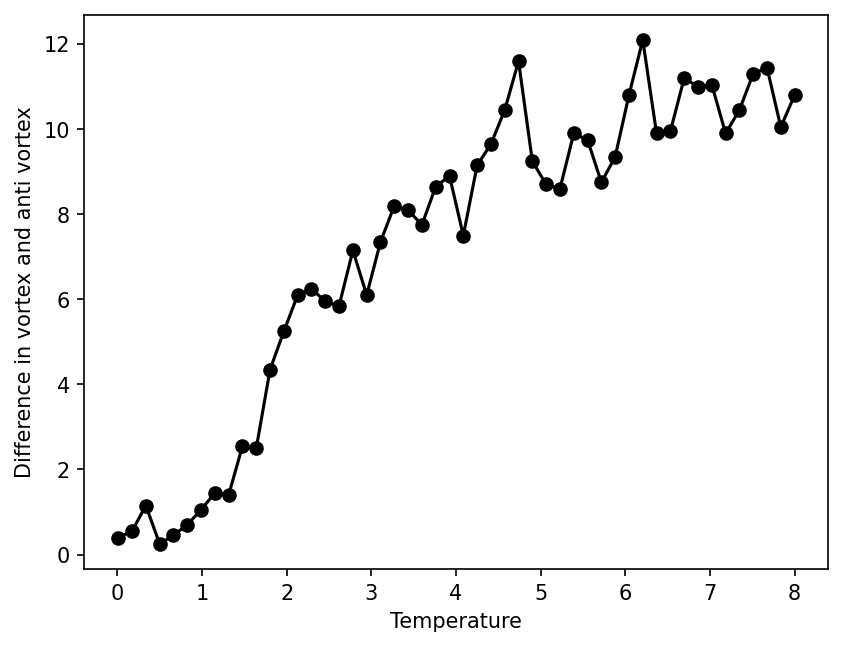

In [14]:
%%time
BKT()

This is a very rough estimate of how the graph should appear for the difference in the number of vortex and antivortex against temperature. It is evident that there is a sharp increase at the point 0.89 and this agrees with the literature value. As the temperature continues to rise, the density of these vortex and antivortex increases, and so does the unpairing. 

<IPython.core.display.Javascript object>


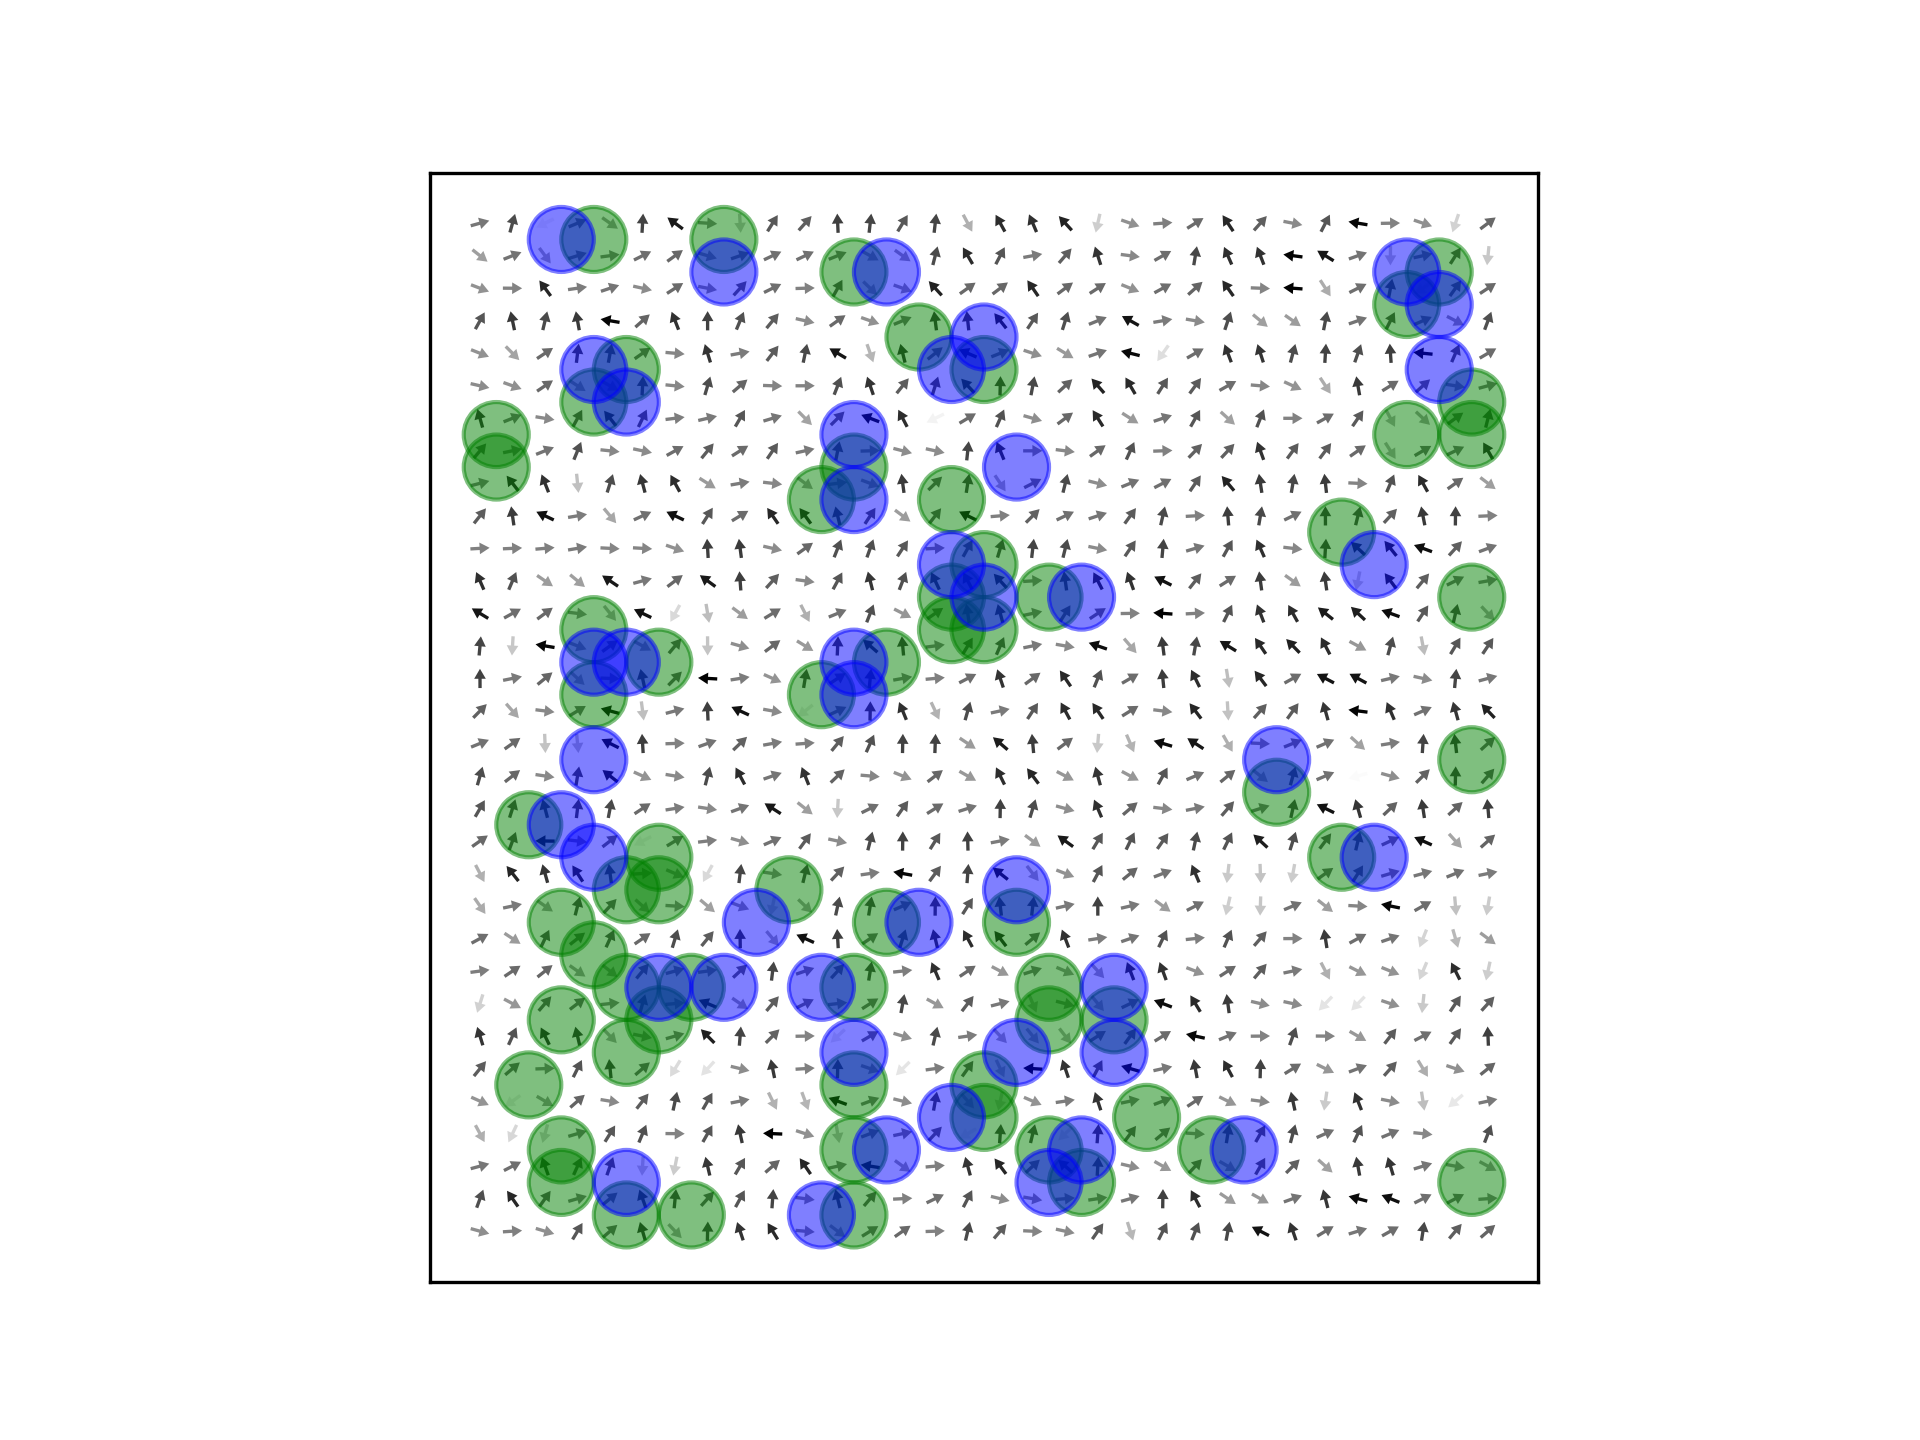

In [15]:
#Here we plot the animation of the system for different temperatures.
%matplotlib notebook
energy, lat3, m= equilibrium(32, T= 3, itr=10000)
Lat3 = np.array(lat3)
animate(Lat3)

The state of the system for one random mc at T = 3, after the system has reached stabilized. The density of the vortex and antivortex is extremely high as expected, and we can also see that there are unpaired vortex and antivortex. 

<IPython.core.display.Javascript object>


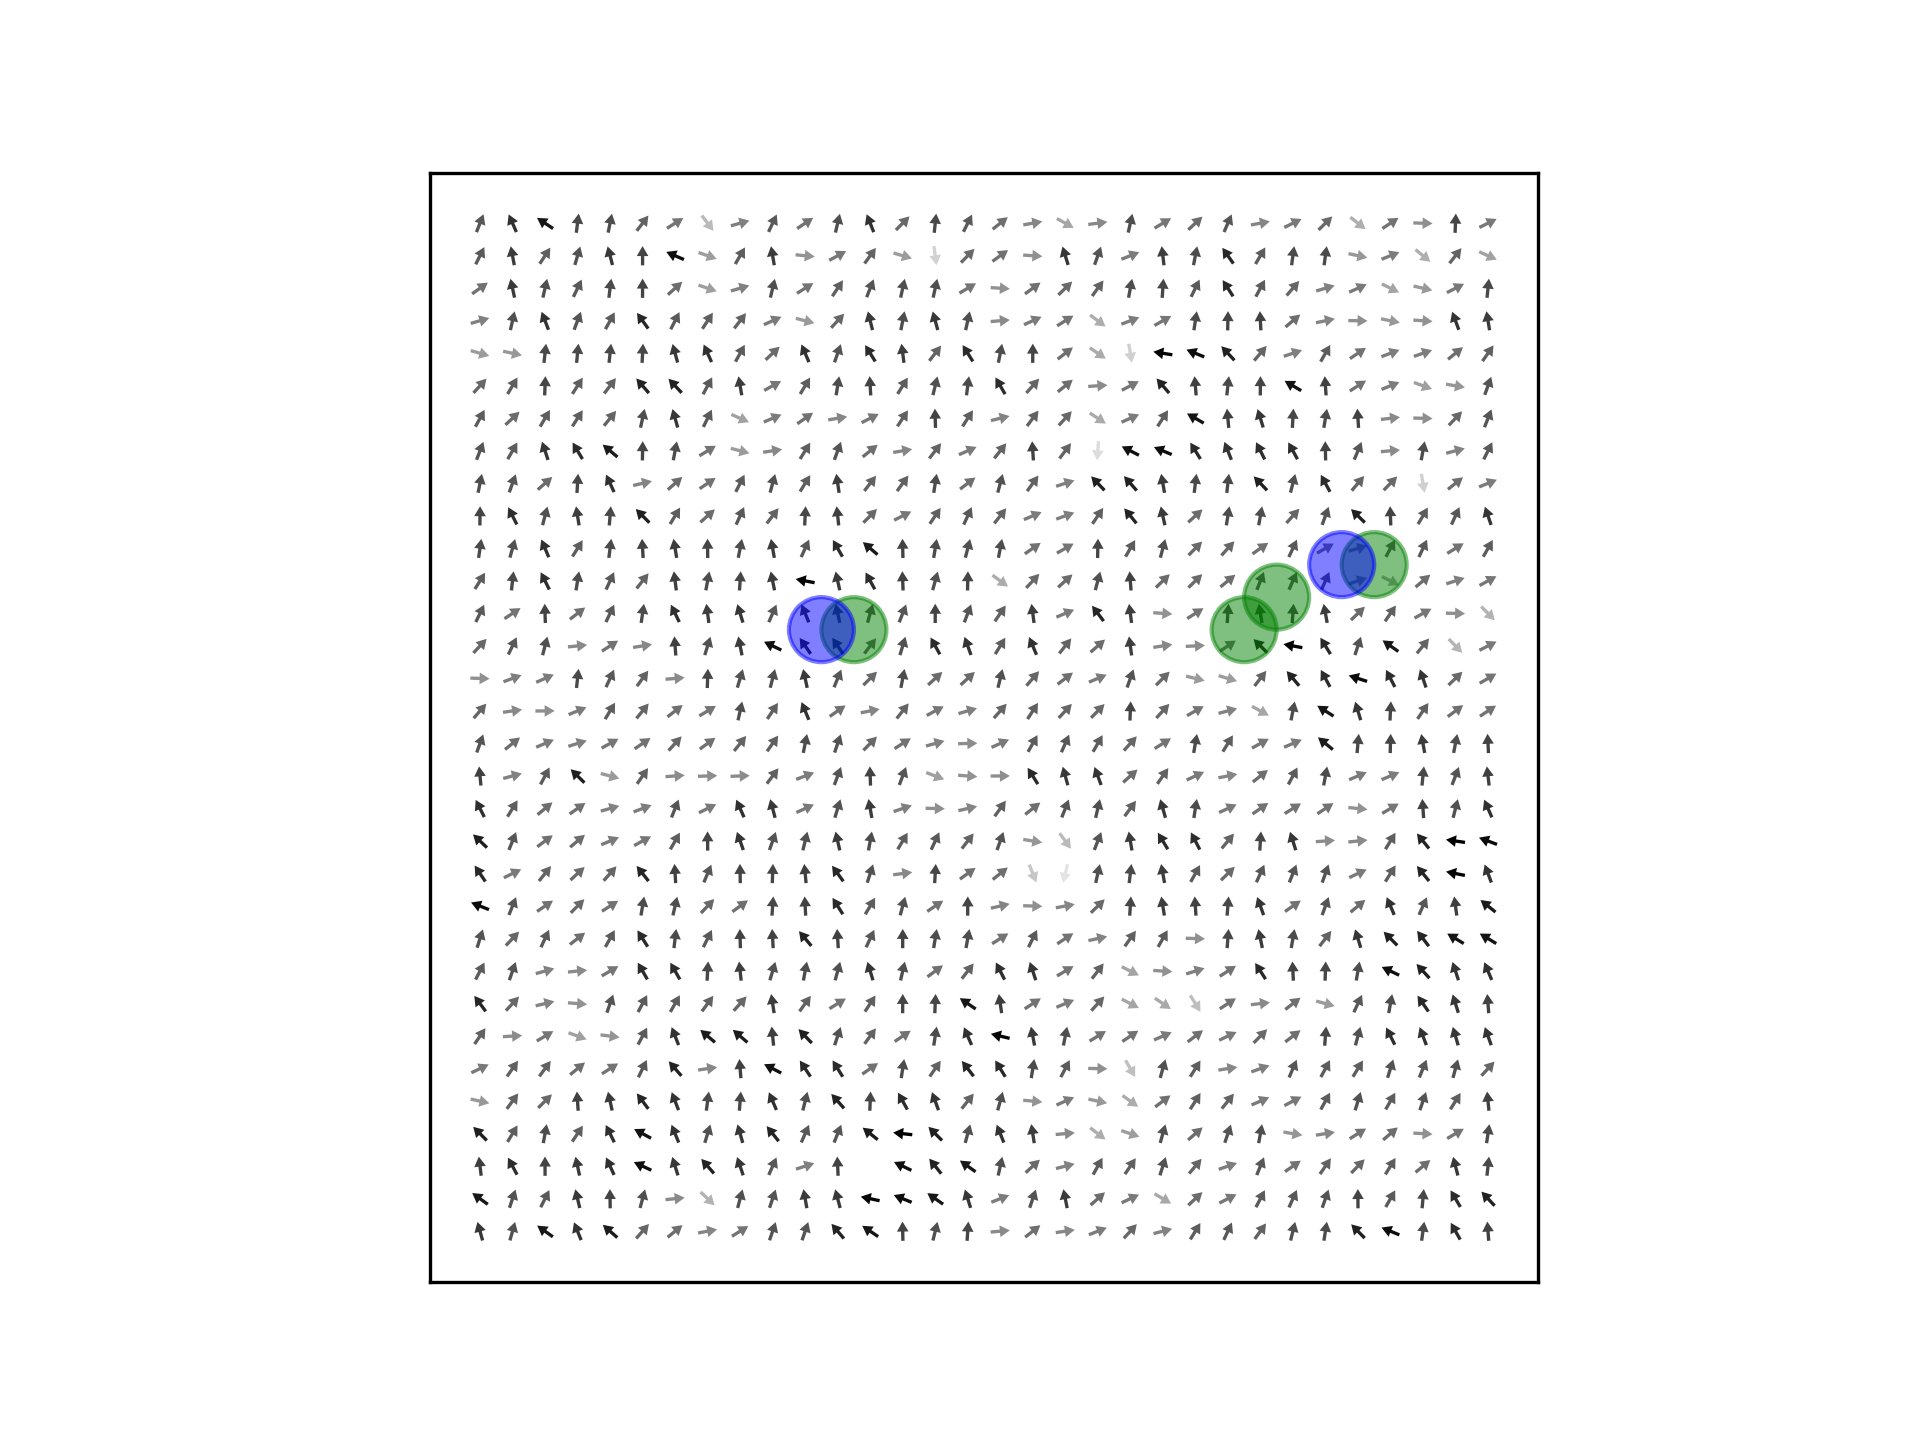

In [16]:
energy, lat3, m= equilibrium(32, T= 0.9, itr=10000)
Lat3 = np.array(lat3)
animate(Lat3)

The above is the snapshot of the system for a temperature just above the critical temperature, T = 0.9. The density of the vortex antivortex is much lesser than the previous, but regardless of this, unpaired vortex and antivortex have begun to appear.  

<IPython.core.display.Javascript object>


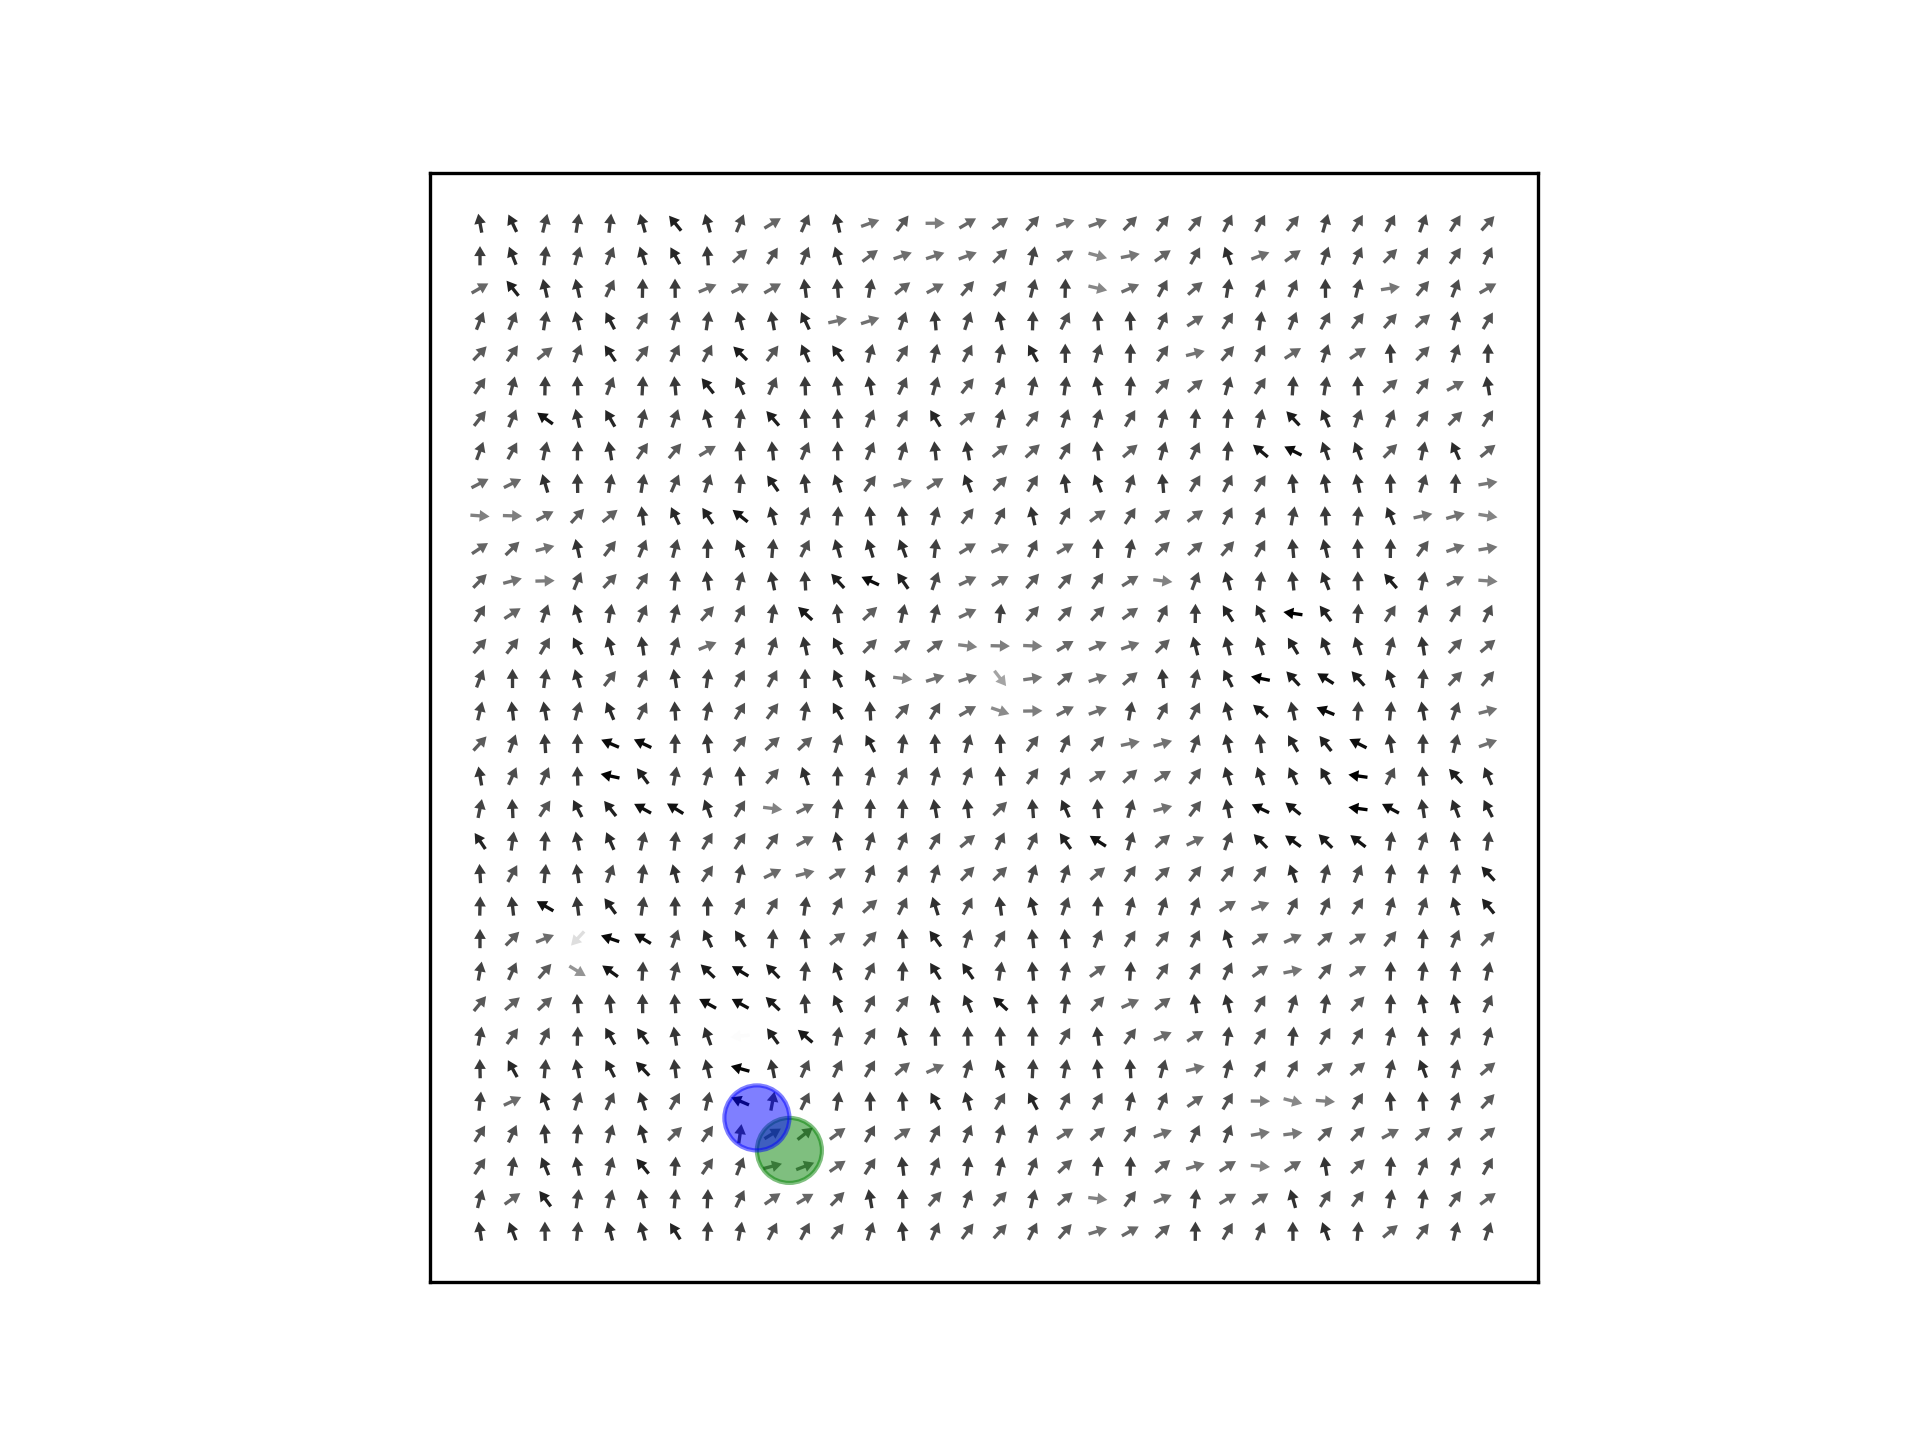

In [21]:
energy, lat3, m= equilibrium(32, T= 0.5, itr=10000)
Lat3 = np.array(lat3)
animate(Lat3)

This is the just for a temperature below the critical temperature T = 0.5. Vortex and anitvortex always appear in pairs and they are extremely rare to find across the Monte Carlo sweeps at this temperature. For lower temperatures, the occurrence of these pairs is lower and lower, exactly what we expect. 